In [1]:
from models.srm_root import SRM_Root

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 9 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

In [4]:
W_syn_init = 0
Tau_syn_init = 1
Delta_syn_init = 0
Delta_spk_init = 0

In [5]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = SRM_Root(C_den, C_syn_e, C_syn_i, T_no, 
            W_syn_init, 
            Tau_syn_init,
            Delta_syn_init, Delta_spk_init,
            device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

51


In [7]:
tau = 10

t = torch.arange(T_no).to(device)
t_tau = t / tau
kern = t_tau * torch.exp(-t_tau)
kern = torch.flip(kern, [0]).reshape(1,1,-1)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_pred, out_filters = model(batch_E_neural, batch_I_neural)
    
    spk_pred = F.conv1d(Z_pred.reshape(1,1,-1), kern, padding=250).flatten()
    batch_spk = F.conv1d(batch_Z.reshape(1,1,-1), kern, padding=250).flatten()
        
    loss = torch.mean((spk_pred - batch_spk)**2)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_Z_pred, test_out_filters = model(test_E_neural, test_I_neural)
        
        test_spk_pred = F.conv1d(test_Z_pred.reshape(1,1,-1), kern, padding=250).flatten()
        test_spk = F.conv1d(Z_test.reshape(1,1,-1), kern, padding=250).flatten()
         
        test_mse = torch.mean((test_spk_pred - test_spk)**2).item()
        test_var = explained_variance_score(test_spk.cpu().detach().numpy(), test_spk_pred.cpu().detach().numpy())
        
        print(i, 
              "TEST_VAR:", np.round(test_var, 5),
              "TEST_MSE:", np.round(test_mse, 5),
              "TAU_E:", np.round(torch.mean(model.Tau_syn_e).item() , 5),
              "TAU_I:", np.round(torch.mean(model.Tau_syn_i).item() , 5)
             )


<ipython-input-7-55da9379f42e>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 TEST_VAR: -22.10267 TEST_MSE: 0.05426 TAU_E: 0.9243 TAU_I: 1.01033
199 TEST_VAR: -9.44964 TEST_MSE: 0.0238 TAU_E: 0.87312 TAU_I: 1.00718
299 TEST_VAR: -6.88253 TEST_MSE: 0.01764 TAU_E: 0.8503 TAU_I: 1.00531
399 TEST_VAR: -4.67476 TEST_MSE: 0.01242 TAU_E: 0.82513 TAU_I: 1.00637
499 TEST_VAR: -3.75886 TEST_MSE: 0.01037 TAU_E: 0.80405 TAU_I: 1.00952
599 TEST_VAR: -2.76927 TEST_MSE: 0.00819 TAU_E: 0.78586 TAU_I: 1.0062
699 TEST_VAR: -2.52899 TEST_MSE: 0.00765 TAU_E: 0.77576 TAU_I: 1.00845
799 TEST_VAR: -2.00809 TEST_MSE: 0.0065 TAU_E: 0.76081 TAU_I: 1.00605
899 TEST_VAR: -1.66287 TEST_MSE: 0.00575 TAU_E: 0.75132 TAU_I: 1.00457
999 TEST_VAR: -1.4953 TEST_MSE: 0.00539 TAU_E: 0.74188 TAU_I: 1.00012
1099 TEST_VAR: -1.43146 TEST_MSE: 0.00524 TAU_E: 0.7294 TAU_I: 0.99822
1199 TEST_VAR: -1.27441 TEST_MSE: 0.0049 TAU_E: 0.72031 TAU_I: 0.99508
1299 TEST_VAR: -1.17984 TEST_MSE: 0.0047 TAU_E: 0.70996 TAU_I: 0.9939
1399 TEST_VAR: -1.02843 TEST_MSE: 0.00437 TAU_E: 0.70089 TAU_I: 0.98857
1499 TEST_VA

KeyboardInterrupt: 

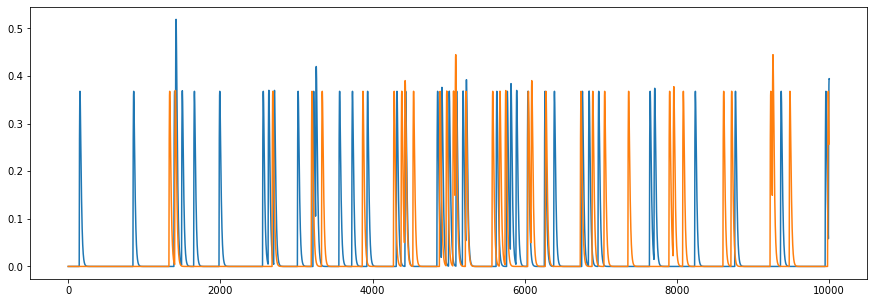

In [8]:
plt.figure(figsize = (15,5))
plt.plot(test_spk.cpu().detach().numpy()[16000:26000])
plt.plot(test_spk_pred.cpu().detach().numpy()[16000:26000])

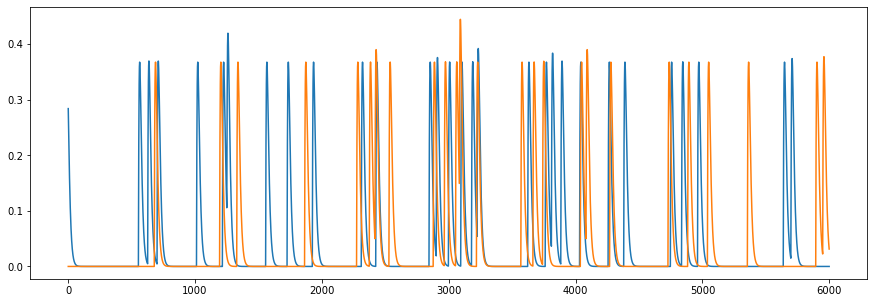

In [9]:
plt.figure(figsize = (15,5))
plt.plot(test_spk.cpu().detach().numpy()[16000:26000][2000:8000])
plt.plot(test_spk_pred.cpu().detach().numpy()[16000:26000][2000:8000])

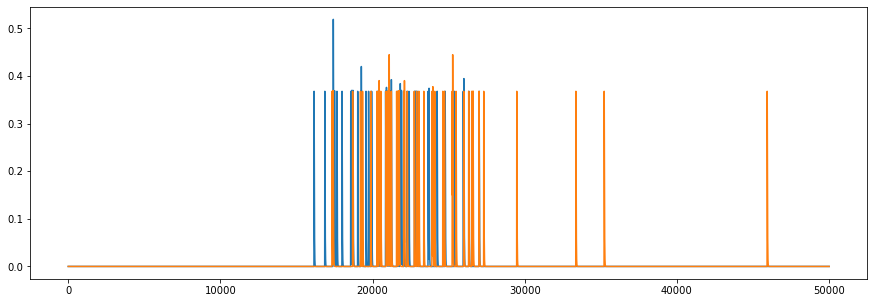

In [10]:
plt.figure(figsize = (15,5))
plt.plot(test_spk.cpu().detach().numpy())
plt.plot(test_spk_pred.cpu().detach().numpy())